# Assessing weather model skill during extreme events: NOAA GFS vs. Sofar Spotter buoy observations of Hurricane Henri

### By: Ciara Dorsay, Data Analyst @ Sofar Ocean

This notebook demonstrates how to remotely access [Sofar Ocean Spotter](https://www.sofarocean.com/products/spotter) and National Oceanic and Atmospheric Administration Global Foreast System (NOAA GFS) significant wave height data ($H_{s}$/Hsig) stored on S3 ([Sofar Ocean Spotter S3 bucket](https://sofar-spotter-archive.s3.amazonaws.com/index.html), [NOAA GFS S3 bucket](https://noaa-gfs-bdp-pds.s3.amazonaws.com/index.html)), collocate the two datasets, and then calculate a skill metric and plot the data during a notable, extreme weather event.

### Sofar Ocean and the Sofar Spotter Archive

[Sofar Ocean](https://www.sofarocean.com/) is an ocean science company based in San Francisco, CA. The company owns and operates a network of ~500 globally distributed, small, met-ocean buoys called “Spotters”, which collect and transmit in-situ observations of ocean wave and near-surface atmospheric conditions via satellite. All wave and derived wind observations from April 2019 to March 2022 have been made publicly available recently via Amazon Web Service’s Open Data Registry. 

In-situ, open-ocean wave observations are historically exceedingly sparse, making this a novel dataset with immense potential for the ocean science community. Observations from the Spotter network have already enabled advancements in extreme weather dynamics, environmental sensing techniques, and validation of other observation platforms.

More recent data can be accessed by contacting our sales team directly at sales@sofarocean.com. 

![Spotter being deployed](spotter_deployment.gif "Sofar Ocean Spotter Deployment")

![Sofar Ocean Weather Dashboard showing locations of free-drifting buoys on 8/8/2024](weather_dash.png "Sofar Ocean Weather Dashboard")

#### Target audience:

* Students/scientists with some degree of familiarity with Python, data processing, and oceanographic observing techniques

#### After the lesson participants will be able to: 

* Query and manipulate met-ocean buoy data from the Spotter Data Archive for analysis
* Identify, query, and subset weather forecast data for analysis
* Collocate point-wise, observational data with gridded weather model output
* Visually and quantitatively compare the skill between observations and weather forecasts


#### Import Python libraries into our project

At this point, we have downloaded everything we need to the machine we are running our project on. In order for this script to be able to access the libraries we've installed, we need to import them here. 

In [1]:
import botocore
import boto3
import cartopy
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import numpy as np
import os
import pandas as pd
import pytz
from scipy.interpolate import interp1d
import xarray as xr

data_path = f"{os.getcwd()}/data"
os.makedirs(data_path, exist_ok=True)

#### Identifying the times of interest

For this tutorial, we are interested in Hurricane Henri, which impacted the northeastern United States and made landfall in Rhode Island on August 22, 2021. 

We are interested in how well NOAA GFS predicted $H_{s}$ in the few days leading up to Hurricane Henri's landfall, so we will specify our start and end dates accordingly.

In [2]:
start_date = datetime(2021, 8, 21, 0, tzinfo=pytz.utc)
end_date = datetime(2021, 8, 23, 0, tzinfo=pytz.utc)

# Create array of dates with hourly frequency
date_range = list(
        pd.date_range(
            start_date,
            end_date,
            freq="h",
        )
    )

#### Download and load Spotter buoy netcdf dataset

#### A note on S3 conventions

In S3, data are stored in distinct buckets. Buckets can denote a given data source (e.g. NOAA GFS data), or an application/downstream environment where the data is intended to be used (e.g. a development vs. production versions of an application). All directories and files within a bucket are called "Objects" which have attributes. 

There are two attributes which are essential to understand when querying data from S3: "Prefix" and "Key". The "Key" is the full path of the object in S3, excluding the bucket and including the filename, whereas the "Prefix" is the portion of "Key" excluding the filename (or lowest level directory).

In [3]:
s3_client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))
s3_sofar_bucket = "sofar-spotter-archive"

spotter_s3_key = "spotter_data_bulk.nc"
spotter_path = f"{data_path}/spotter_data_bulk.nc"

# Only download if file does not exist locally
if not os.path.exists(spotter_path):
    s3_client.download_file(s3_sofar_bucket, spotter_s3_key, spotter_path)

ds = xr.open_dataset(spotter_path, engine="netcdf4")

# Look at the output - note, coordinate "trajectory" indicates the unique device IDs
ds

<xarray.Dataset>
Dimensions:                (index: 6390651, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] ...
  * trajectory             (trajectory) <U12 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    significantWaveHeight  (index) float64 ...
    peakPeriod             (index) float64 ...
    meanPeriod             (index) float64 ...
    peakDirection          (index) float64 ...
    peakDirectionalSpread  (index) float64 ...
    meanDirection          (index) float64 ...
    meanDirectionalSpread  (index) float64 ...
    latitude               (index) float64 ...
    longitude              (index) float64 ...
    rowsize                (trajectory) int64 ...
Attributes:
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters
    institution:    Sofar Ocean
    source:         Spotter wave buoy
    creation_date:  2023-10-18 00:43:55.333537
    author:         Isabel A. Houghton
    email:          isabel.houghton@sofarocean.com
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...

#### Load forecasts from NOAA GFS

When working with weather model data, it is important to verify that the data is available for the variables and times of interest. These can be subject to change, depending on your data source.

In [4]:
# Define S3 bucket where forecast data located
s3_noaa_bucket = 'noaa-gfs-bdp-pds'

# Make a directory to store forecasts
noaa_gfs_data_path = f"{data_path}/noaa_gfs"
os.makedirs(noaa_gfs_data_path, exist_ok=True)

# Get S3 prefix - will need to be modified if interested in different init times, variables
noaa_gfs_prefix = f"gfs.{start_date.strftime('%Y%m%d')}/00/wave/gridded/"

# Define constructor to generate the filenames to be queried

def s3_filename_generator(forecast_hour: int, init_hour: int=0):
    return f"gfswave.t{f'{init_hour:02}'}z.global.0p16.f{f'{forecast_hour:03}'}.grib2"

list_of_model_datasets = []
for t in range(len(date_range)):
    data_fname = s3_filename_generator(forecast_hour=t, init_hour=0)
    data_key = noaa_gfs_prefix + data_fname
    downloaded_file_name = f"{noaa_gfs_data_path}/{data_fname}"
    
    if not os.path.exists(downloaded_file_name):
        print(f"Downloading {data_key}")
        s3_client.download_file(s3_noaa_bucket, data_key, downloaded_file_name)

    # Open NOAA GFS files into xr.Dataset
    list_of_model_datasets.append(xr.open_dataset(downloaded_file_name, engine="cfgrib")["swh"])

In [5]:
# Concatenate hourly datasets into single dataset
full_noaa_ds = xr.concat(list_of_model_datasets, dim="valid_time")

#### Subset Spotter data by time and coordinates of observations

![Tropical storm winds associated with Hurricane Henri](henri.jpeg "Spatial extent of Henri winds")

In [6]:
# Spotter dataset times have format np.datetime64, need to convert start/end dates to same dtype
start_npy = pd.Timestamp(start_date-timedelta(minutes=30)).to_numpy()
end_npy = pd.Timestamp(end_date+timedelta(minutes=30)).to_numpy()

lons_of_interest = [-80, -60]
lats_of_interest = [25, 45]

#### Filter relevant Spotters and convert to pandas DataFrame

Model data available on the hour, and Spotter data is available hourly, but from whatever time the device was first turned on. As such, the frequency varies from device to device, whereas the model time array is constant and less burdensome to use. 

In [7]:
# Create array that points to indices for each trajectory
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

# List to store interpolated dataframes, parsed by SPOT-ID
spotter_df_dict = {}

for sp_idx, spotter_id in enumerate(ds.trajectory):

    # "spid" is technically an array, want to extract the string name alone
    spotter_id = spotter_id.item()
    sli = slice(traj_idx[sp_idx], traj_idx[sp_idx+1])

    
    # Slice index to extracted data associated with drifter
    curr_df = pd.DataFrame({
         "latitude": ds.latitude[sli],
         "longitude": ds.longitude[sli], 
         "time": ds.time[sli],
         "significantWaveHeight": ds.significantWaveHeight[sli],
                              })
    curr_df.sort_values(by=["time"], inplace=True)
    curr_df = curr_df[(curr_df["time"].between(start_npy, end_npy)) &
    (curr_df["longitude"].between(lons_of_interest[0], lons_of_interest[1])) &
    (curr_df["latitude"].between(lats_of_interest[0], lats_of_interest[1]))]
    

    if len(curr_df) > 1:  # can't interpolate with < 2 consecutive values
        spotter_df_dict[spotter_id] = curr_df

#### Interpolate Spotter data to the hour

In [8]:
new_df_list = []
var_list = ["latitude", "longitude", "time", "significantWaveHeight"]

for spotter_id in spotter_df_dict:

    # Create new dataframe to store interpolated values
    curr_data = spotter_df_dict[spotter_id]
    new_df = pd.DataFrame()

    # Set up interpolation function
    earliest_interp_time = (
        curr_data.loc[curr_data.index.values[0], ["time"]].item().ceil("h")
    )
    latest_interp_time = (
        curr_data.loc[curr_data.index.values[-1], ["time"]].item().floor("h")
    )
    new_df["time"] = pd.date_range(
        start=earliest_interp_time, end=latest_interp_time, freq="h"
    )
    interp_times = [
        t.to_datetime64().astype("int64") // 1e9 for t in new_df["time"]
    ]

    for var in var_list:
        
        if var == "longitude":
            # Need to account for if Spotter crosses meridian over time period of interpolation
            f_interp = interp1d(
                [
                    t.to_datetime64().astype("int64") // 1e9
                    for t in curr_data["time"]
                ],
                curr_data[var],
                kind="nearest",
            )
        else:
            f_interp = interp1d(
                [
                    t.to_datetime64().astype("int64") // 1e9
                    for t in curr_data["time"]
                ],
                curr_data[var],
                kind="linear",
            )

        # Add processed values to new df
        interp_vals = f_interp(interp_times)
        new_df[var] = interp_vals

    new_df["spotter_id"] = spotter_id
    new_df_list.append(new_df)

mega_spotter_df = pd.concat(new_df_list).sort_values(by="time", ignore_index=True)
mega_spotter_df["timestamp"] = pd.to_datetime(mega_spotter_df["time"], utc=True)

# Convert longitudes to 0, 360
mega_spotter_df["longitude"] = mega_spotter_df["longitude"].values % 360

#### Collocate Spotter data with weather model forecasts

In [9]:
mega_spotter_df["model_value"] = np.nan

for curr_time in mega_spotter_df["timestamp"].unique():

    # Select data corresponding to given time
    curr_model_ds = full_noaa_ds.sel(valid_time=curr_time.to_datetime64())
    curr_spotter_df = mega_spotter_df[mega_spotter_df["timestamp"] == curr_time]

    # Interpolate
    collocated_vals = (
            curr_model_ds.interp(
                latitude=xr.DataArray(curr_spotter_df.latitude.values),
                longitude=xr.DataArray(curr_spotter_df.longitude.values),
                method="nearest",  # when linearly interpolating, have to add logic for longitude wrapping
            ).to_numpy()
        )

    # Add values to Spotter dataframe
    mega_spotter_df.loc[mega_spotter_df["timestamp"] == curr_time, "model_value"] = collocated_vals

# Calculate difference between model and observations, add as new column
mega_spotter_df["error"] = mega_spotter_df["model_value"] - mega_spotter_df["significantWaveHeight"]

#### Calculate skill between Sofar Spotter buoys and NOAA GFS

In [10]:
bias_by_hour = {}

for curr_time in mega_spotter_df["timestamp"].sort_values():
    forecast_hour = int((curr_time - pd.Timestamp(start_date)).total_seconds()/3600)
    curr_df = mega_spotter_df[mega_spotter_df["timestamp"] == curr_time]
    bias_by_hour[forecast_hour] = np.nanmean(curr_df["error"])

#### Plot Spotter positions and corresponding model value over time period

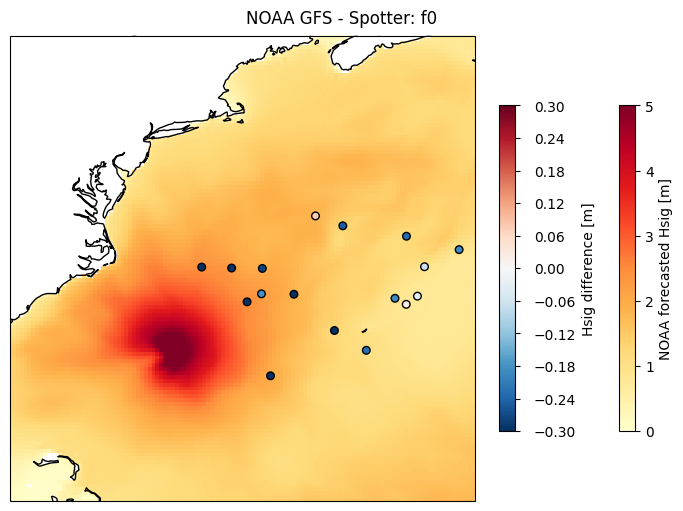

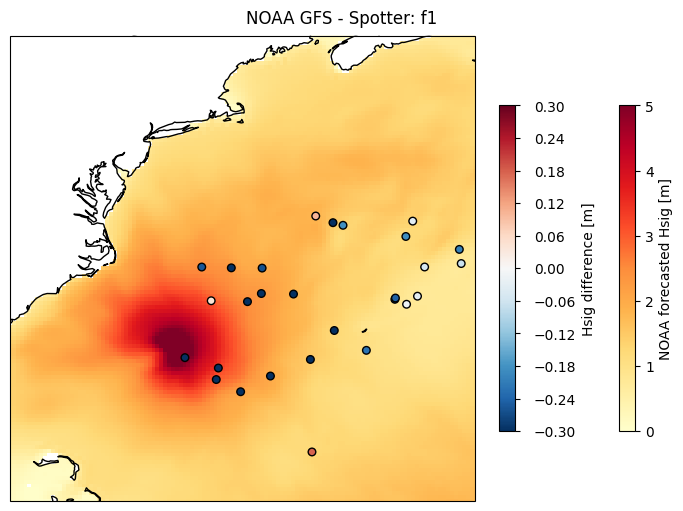

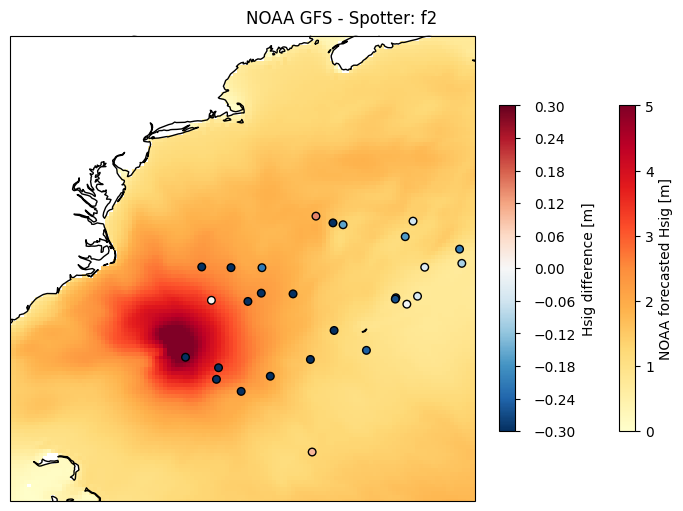

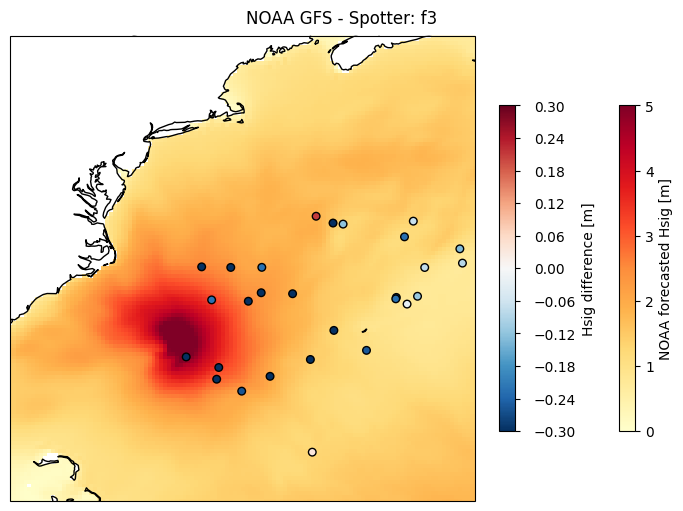

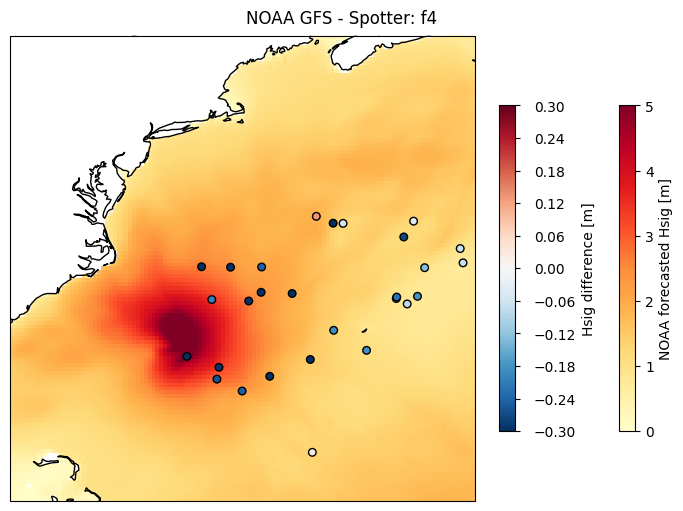

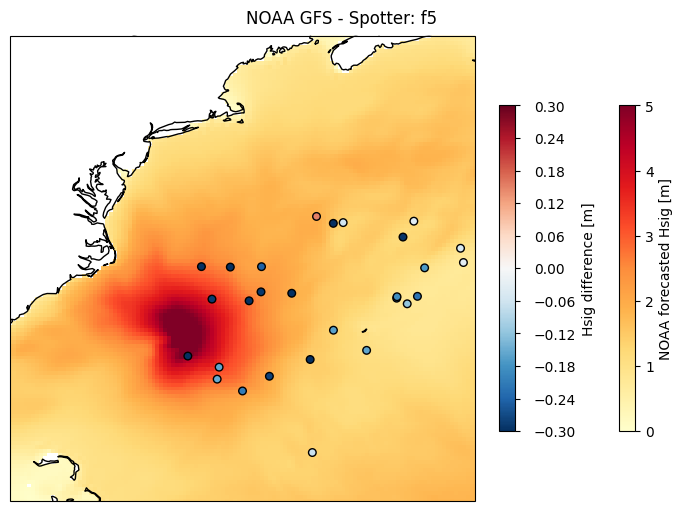

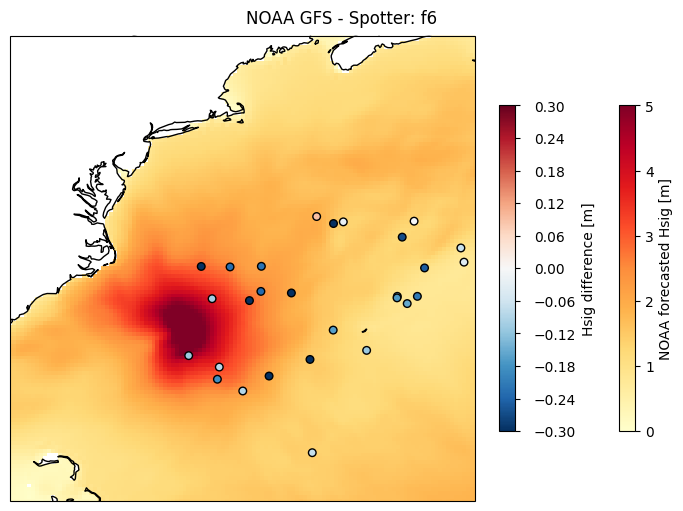

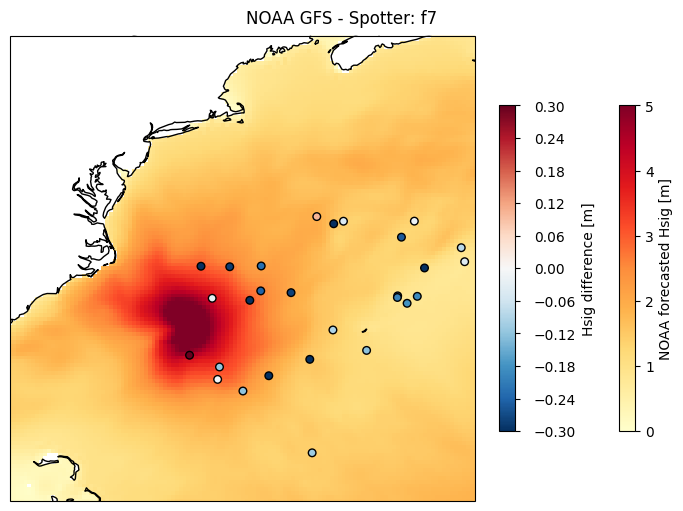

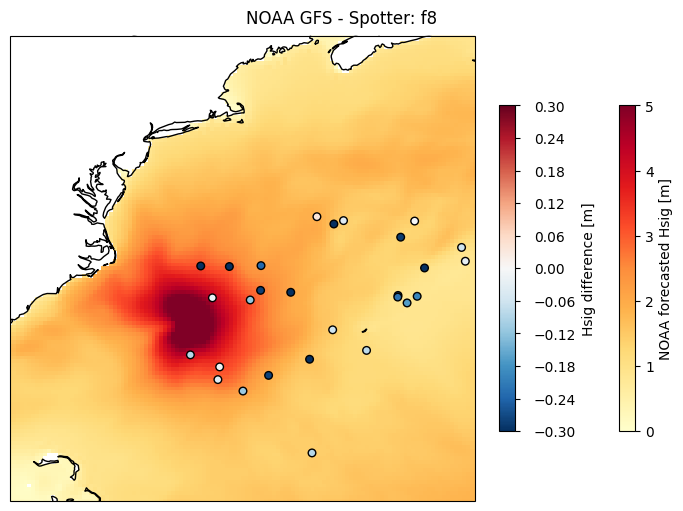

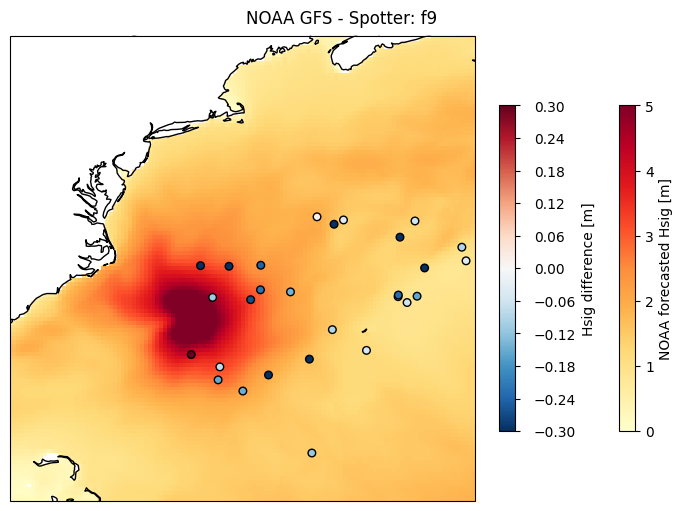

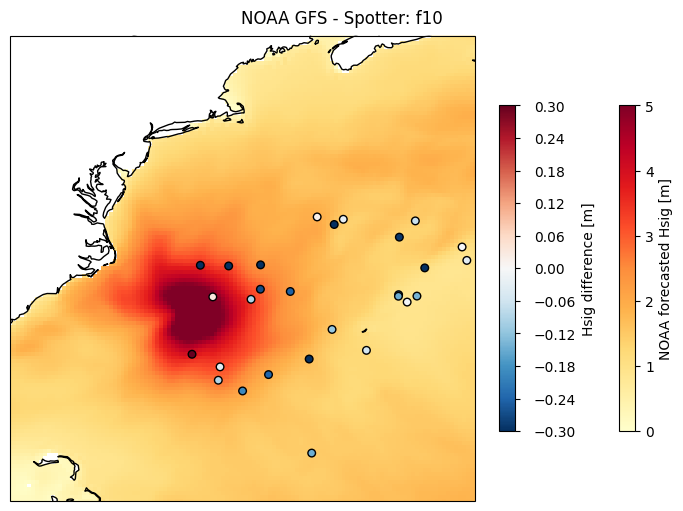

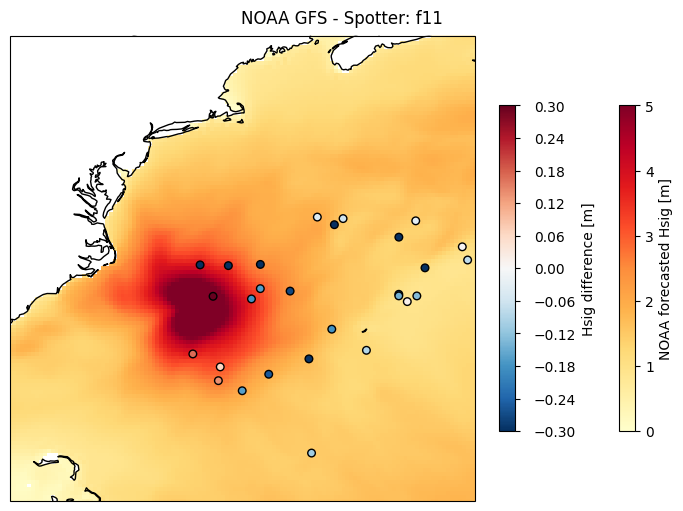

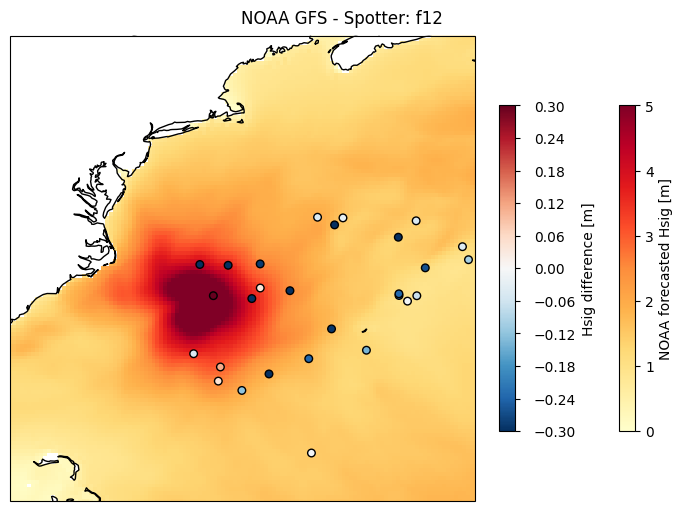

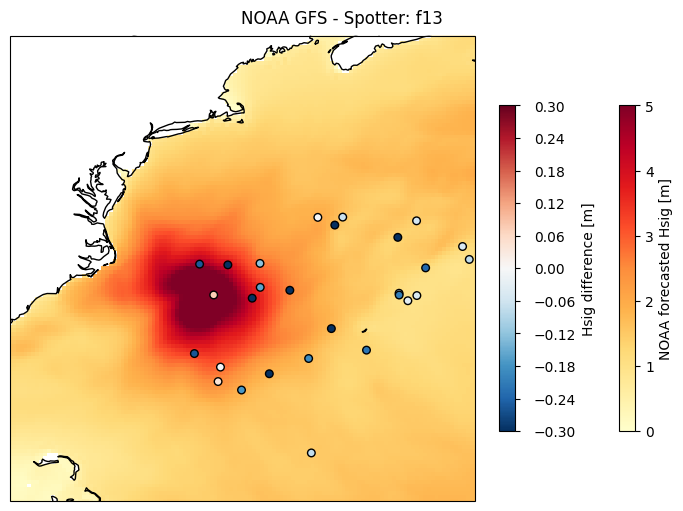

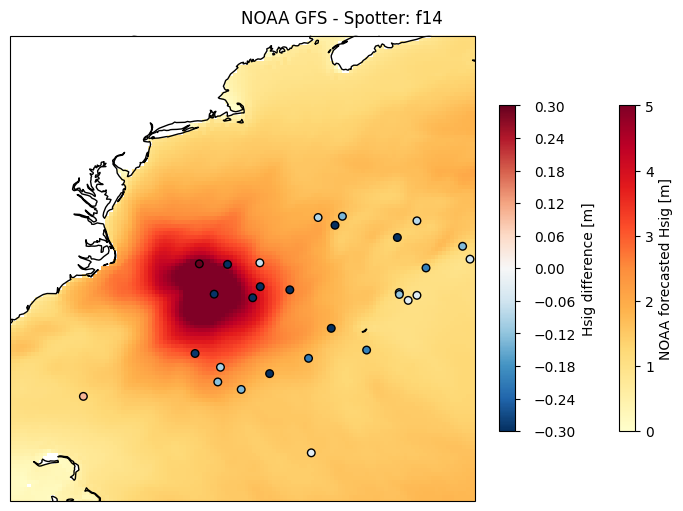

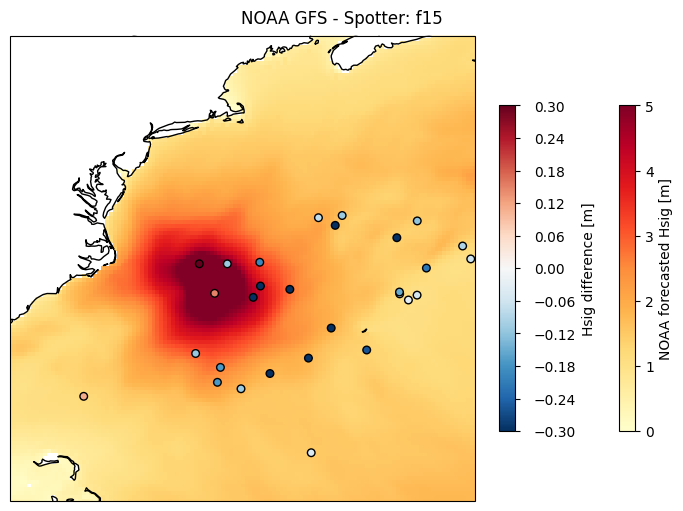

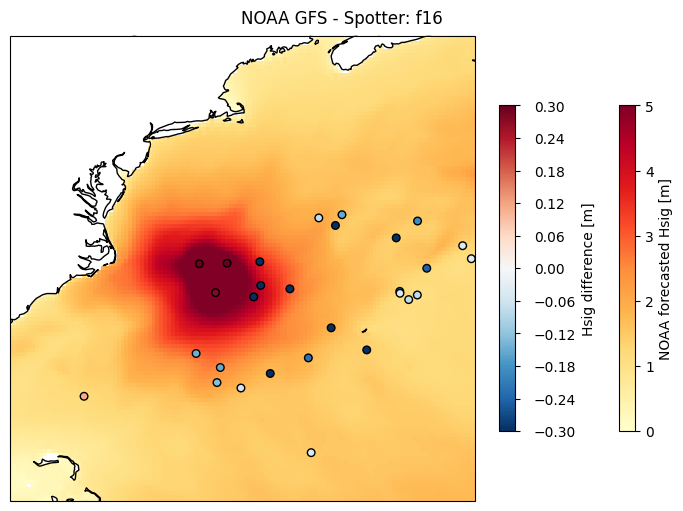

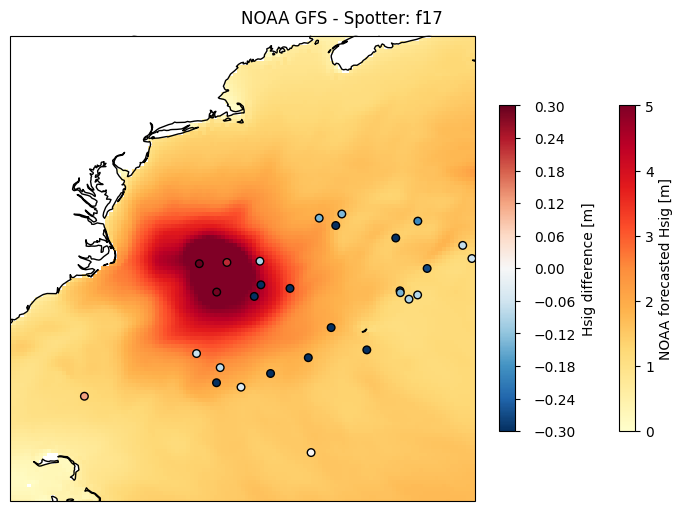

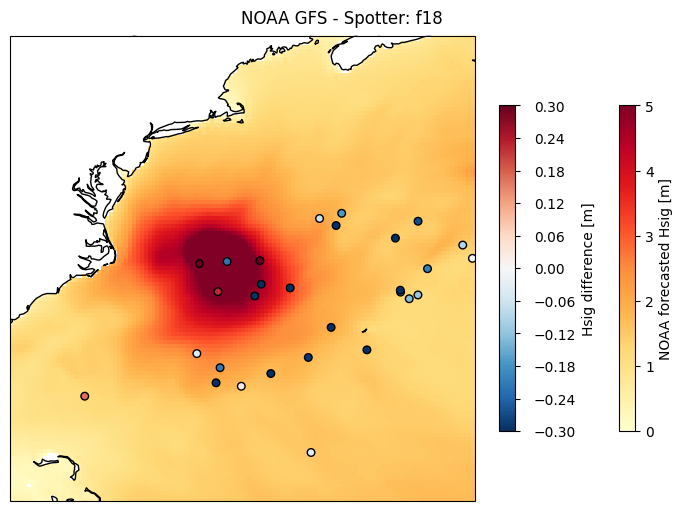

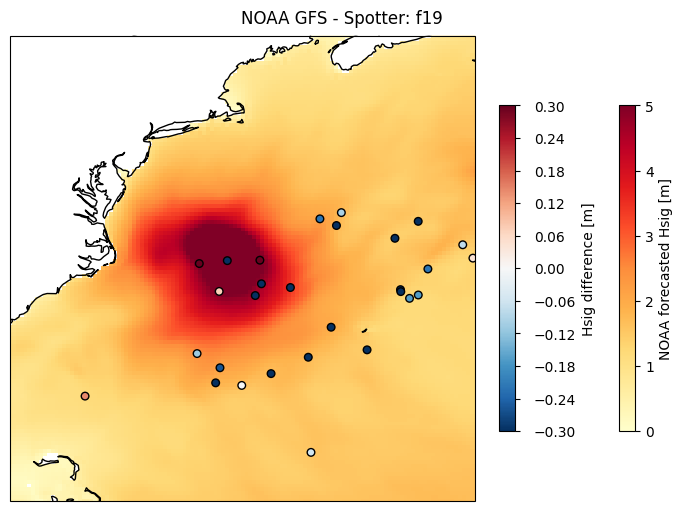

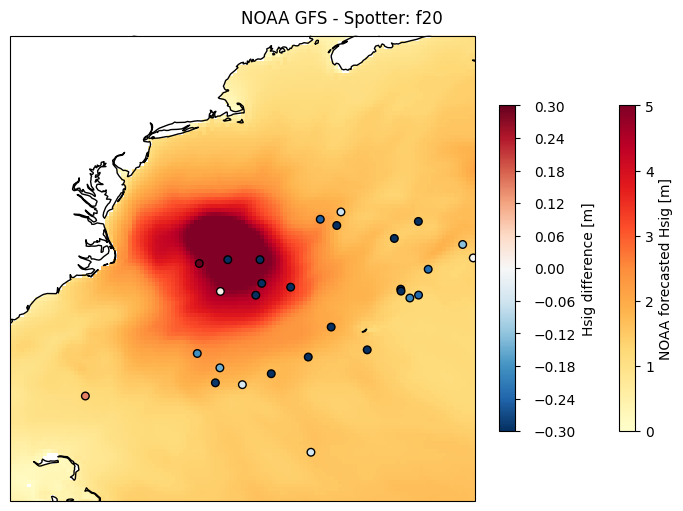

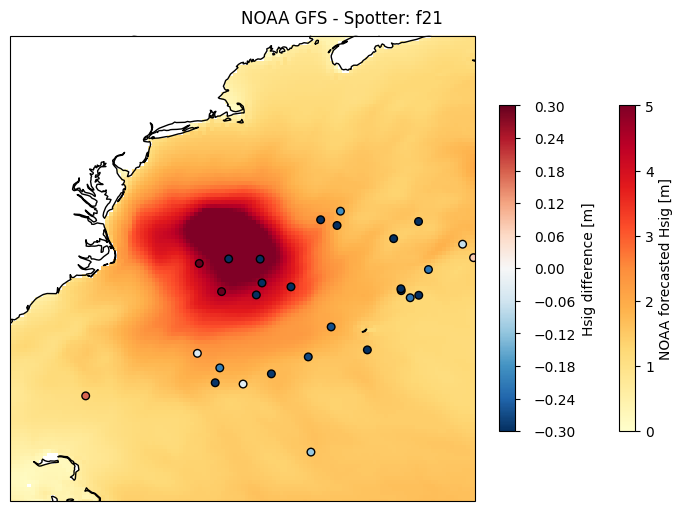

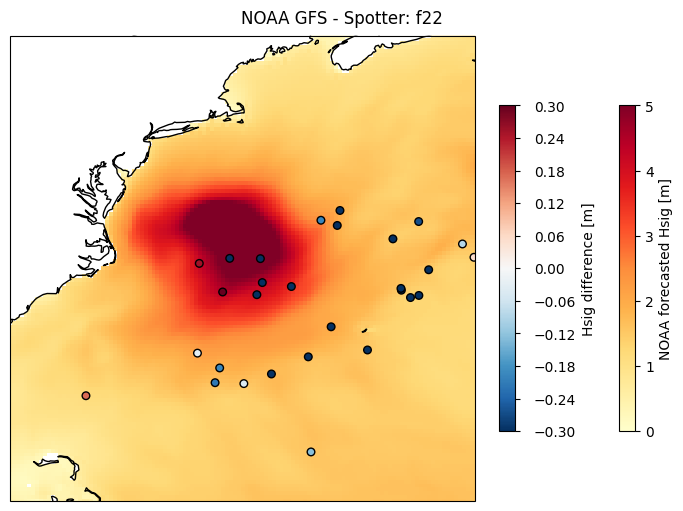

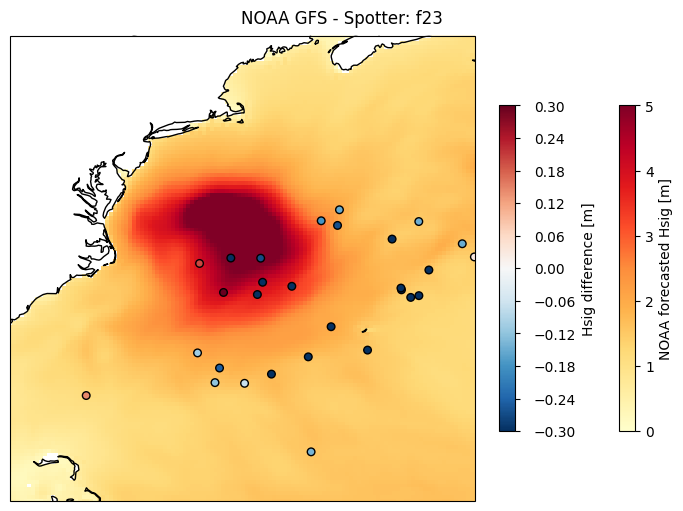

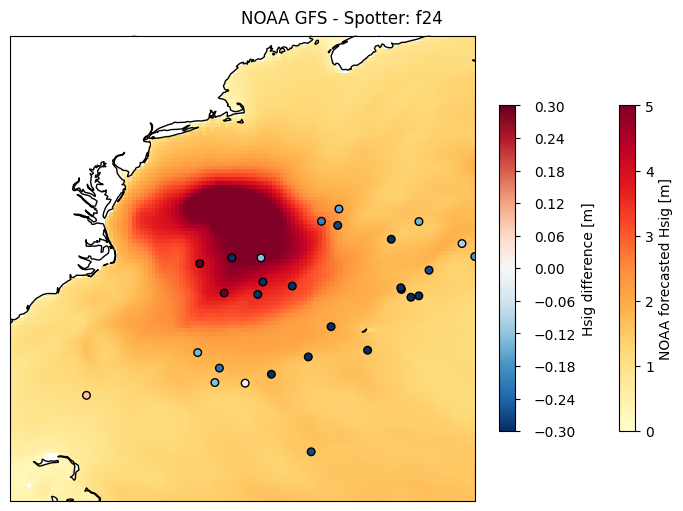

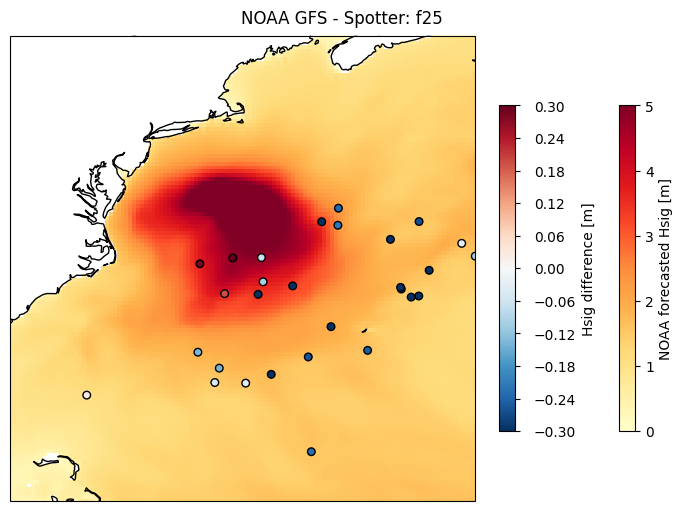

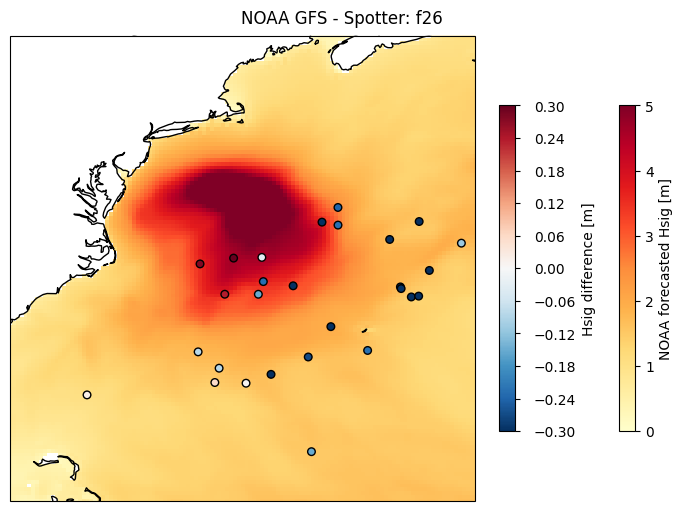

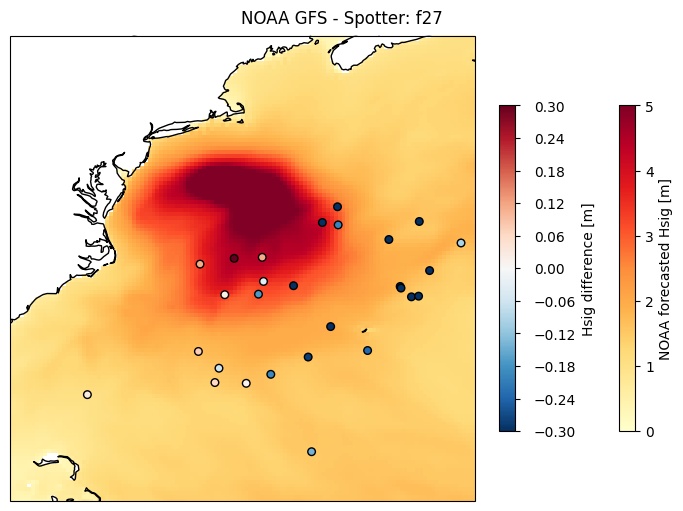

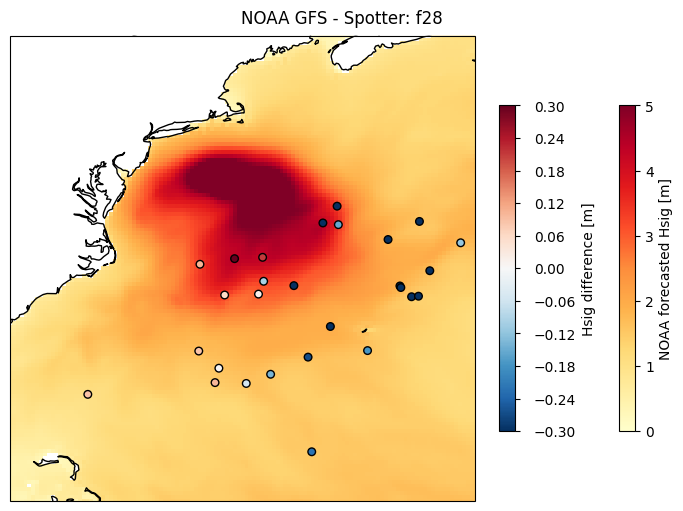

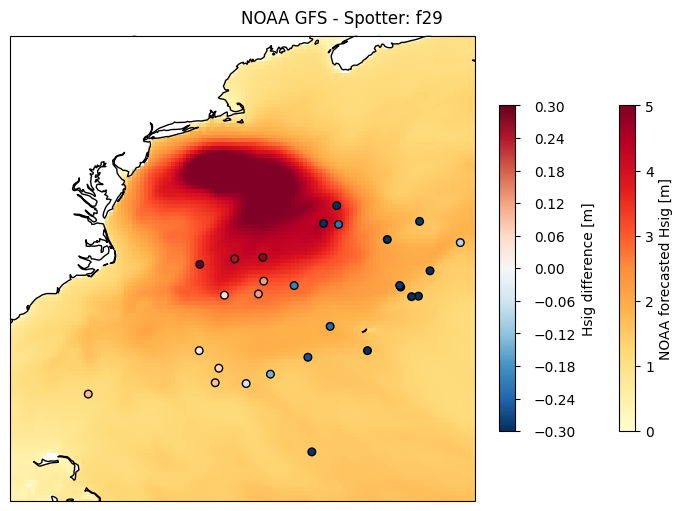

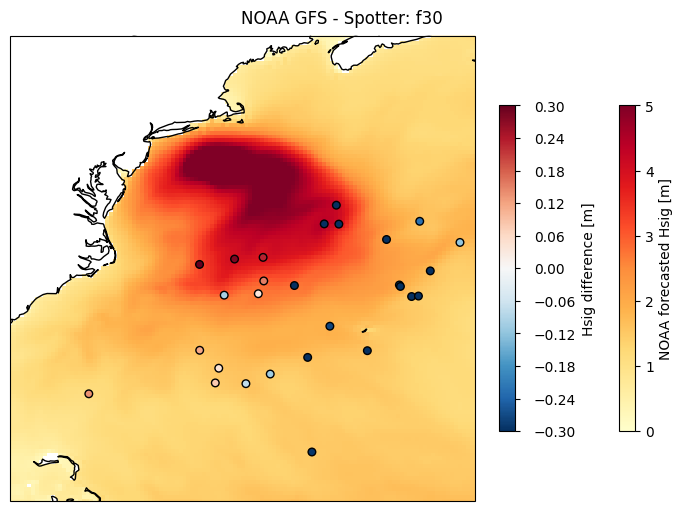

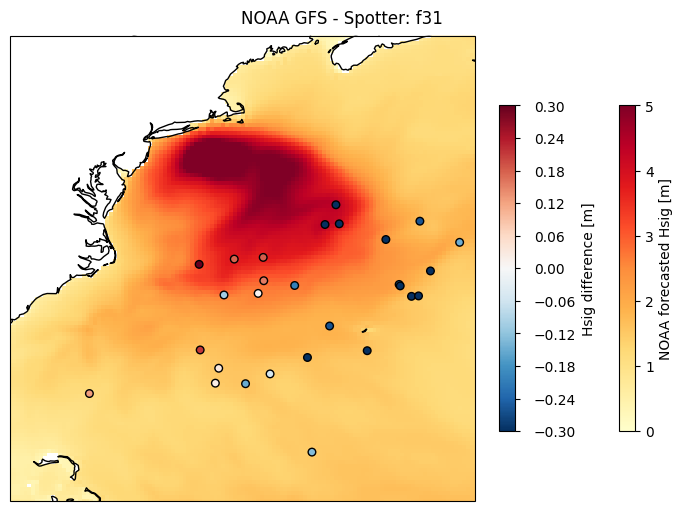

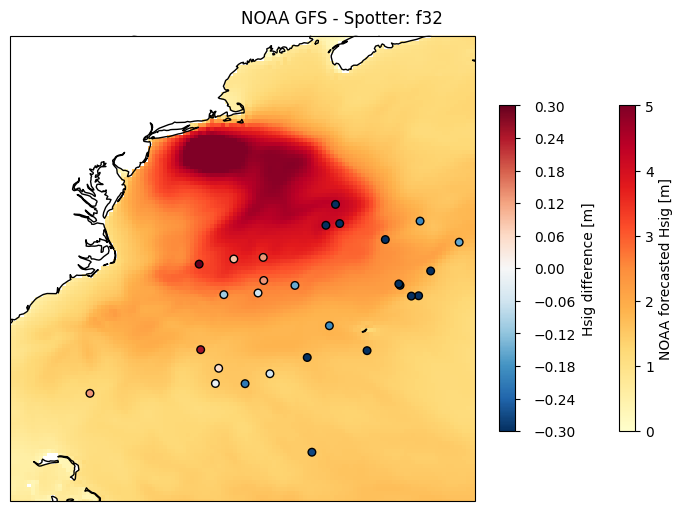

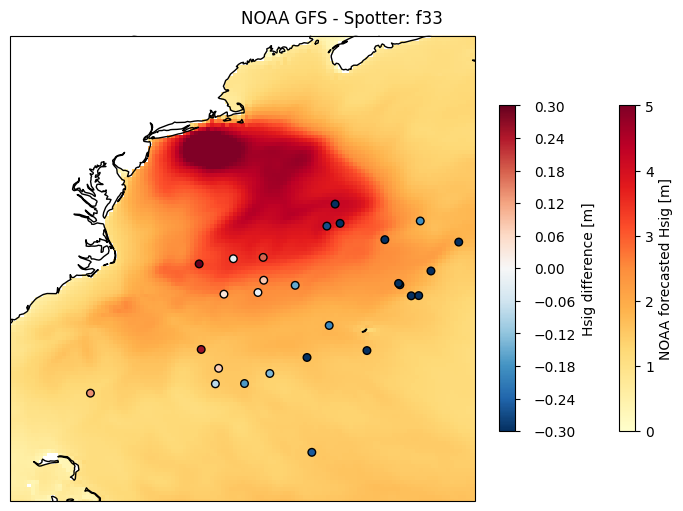

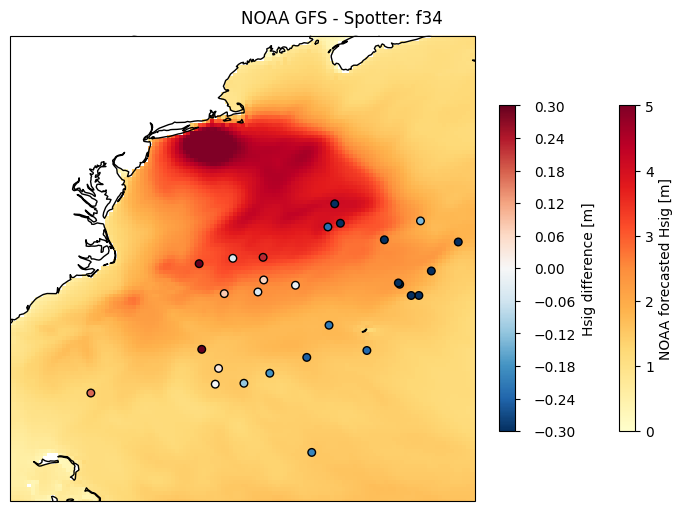

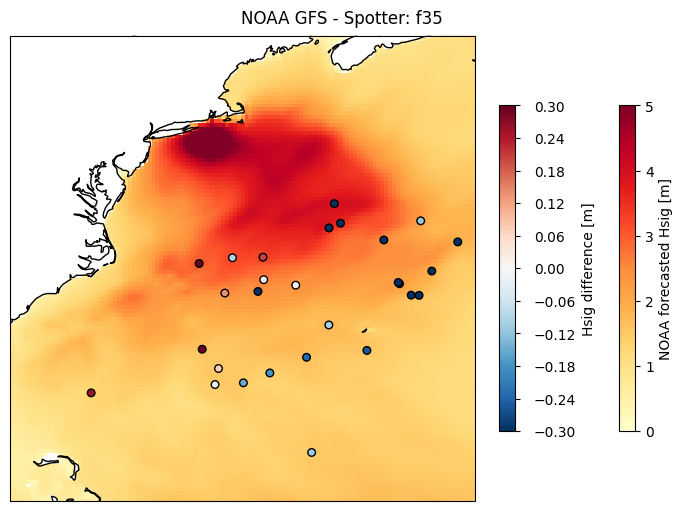

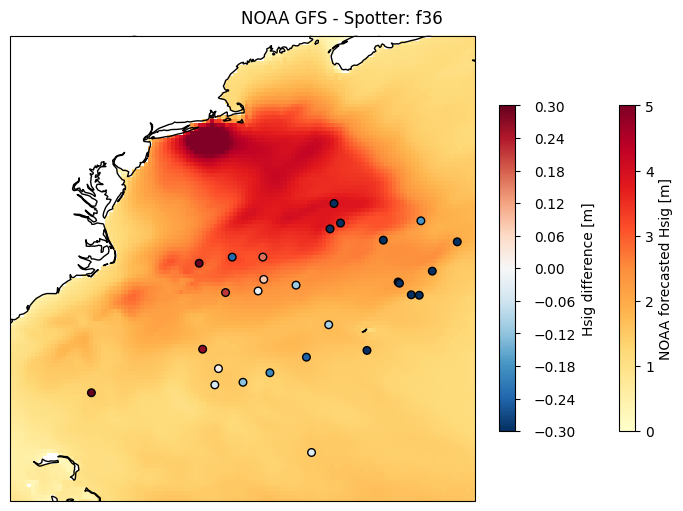

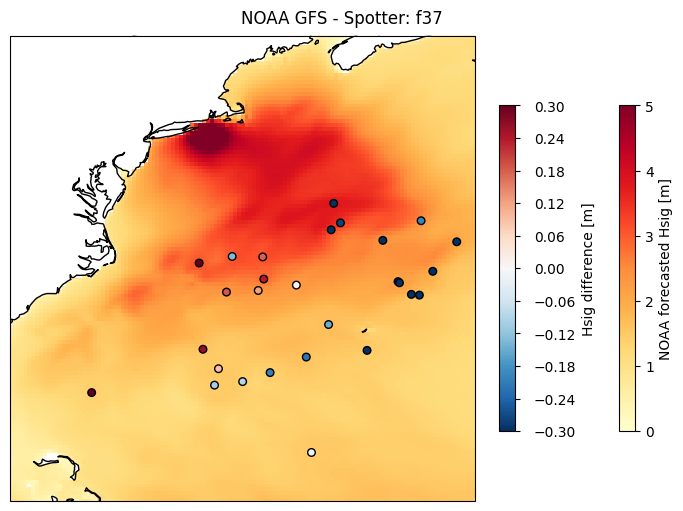

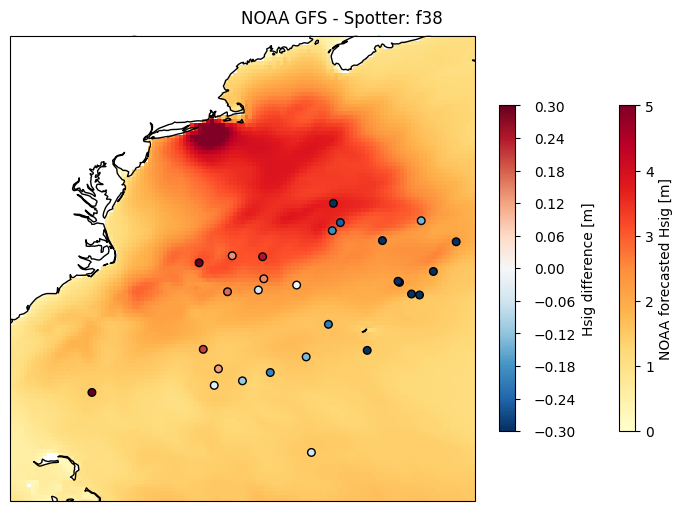

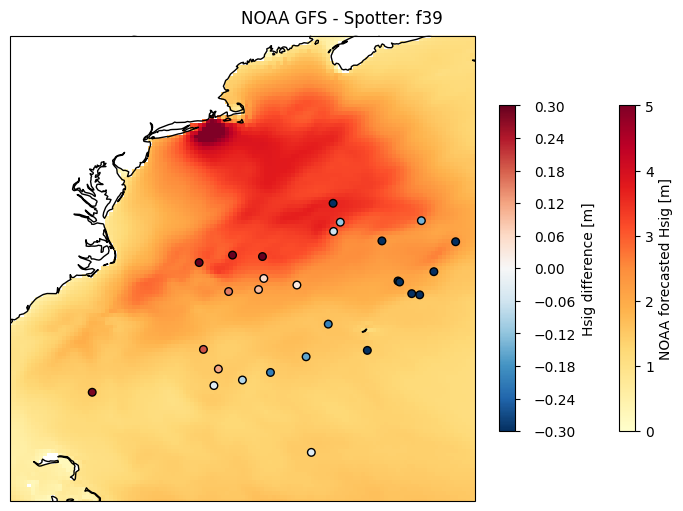

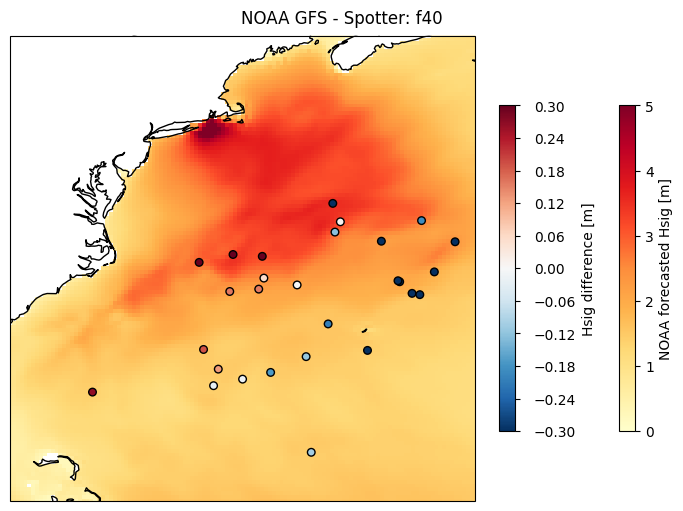

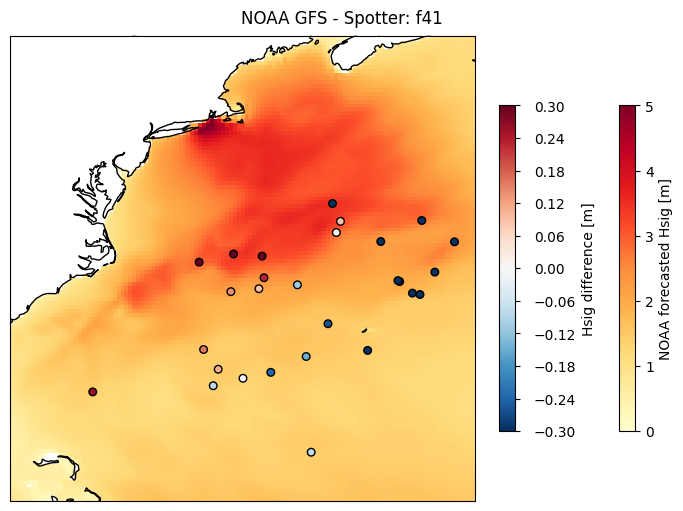

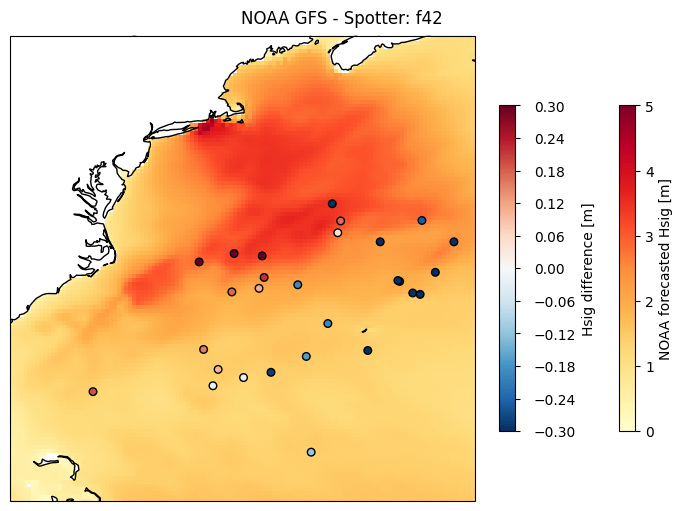

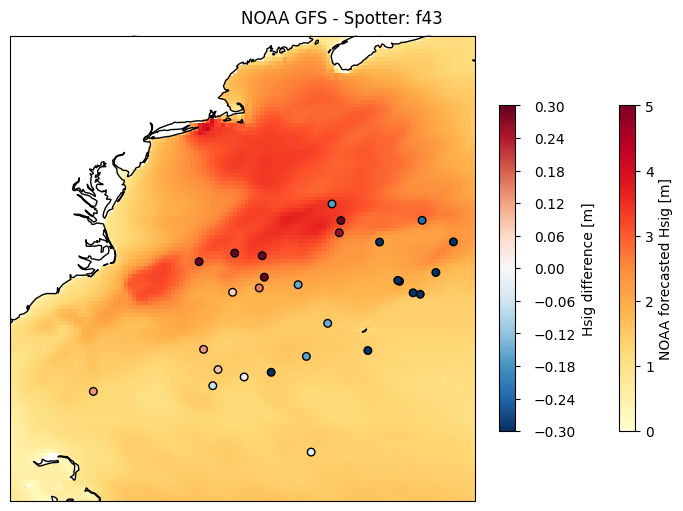

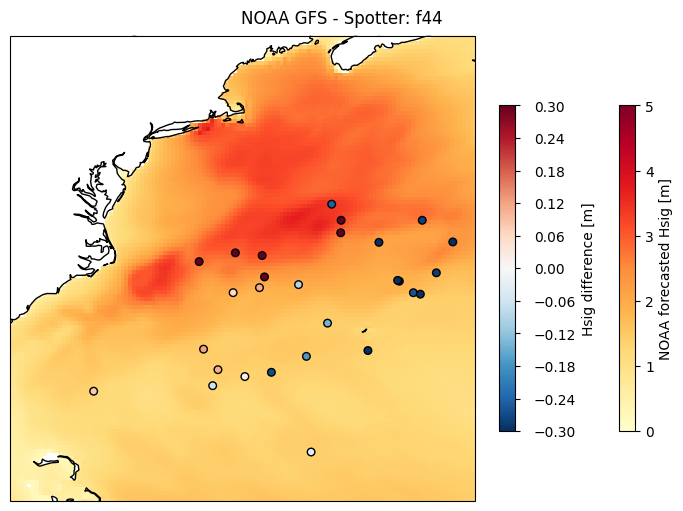

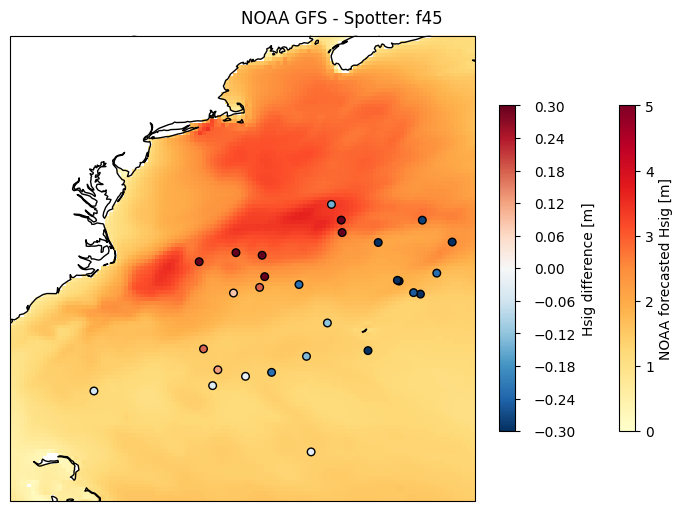

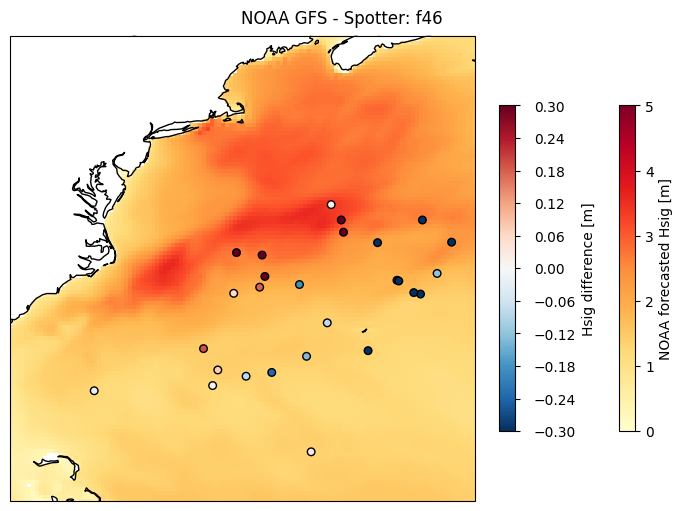

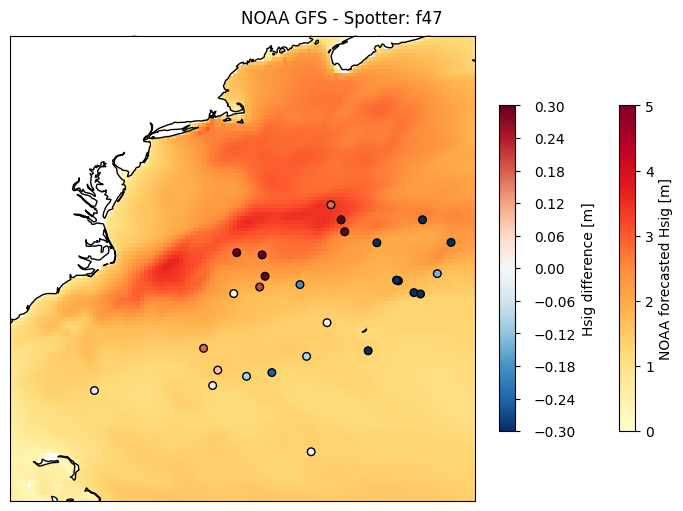

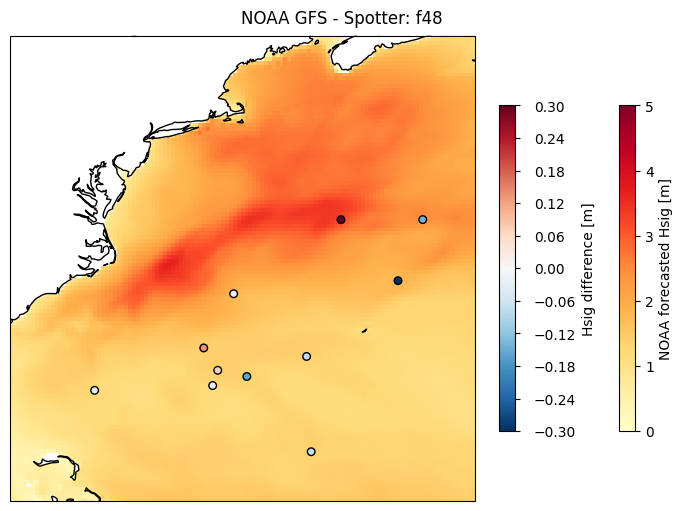

In [11]:
cbar_min = -0.3
cbar_max = 0.3
noaa_min = 0
noaa_max = 5
proj = ccrs.PlateCarree()

for curr_time in mega_spotter_df["timestamp"].unique():
    forecast_hour = int((curr_time - pd.Timestamp(start_date)).total_seconds()/3600)
    curr_df = mega_spotter_df[mega_spotter_df["timestamp"] == curr_time]
    curr_noaa_data = full_noaa_ds.sel(valid_time=curr_time.to_numpy())
    
    # Set up figure, axes
    fig, axs = plt.subplots(
        nrows=1,
        figsize=(12, 5),
        subplot_kw={"projection": proj},
        layout="compressed",
    )
    fig.suptitle(f"NOAA GFS - Spotter: f{forecast_hour}")
    axs.set_extent([
                    lons_of_interest[0],
                    lons_of_interest[1],
                    lats_of_interest[0],
                    lats_of_interest[1],
                    ],
                    crs=ccrs.PlateCarree())

    # Plot NOAA model data in the background
    curr_noaa_data = curr_noaa_data.plot(
                    ax=axs,
                    cmap="YlOrRd",
                    cbar_kwargs={
                        "orientation": "vertical",
                        "shrink": 0.7,
                        "label": "NOAA forecasted Hsig [m]",
                    },
                )
    plt.title("")

    # Plot model/Spotter observations
    curr_diff_plot = axs.scatter(
                        x=curr_df["longitude"].values,
                        y=curr_df["latitude"].values,
                        c=curr_df["error"].values,
                        s=30,
                        cmap="RdBu_r",
                        edgecolors=mpl_colors.colorConverter.to_rgba(
                            "black", alpha=1
                        ),
                        transform=proj,
                    )

    
    # Set limits of color bars
    curr_diff_plot.set_clim(cbar_min, cbar_max)
    curr_noaa_data.set_clim(noaa_min, noaa_max)

    cbar_errors = fig.colorbar(
        curr_diff_plot,
        ax=axs,
        ticks=np.arange(
            cbar_min,
            cbar_max + (cbar_max + np.abs(cbar_min)) / 10,
            (cbar_max + np.abs(cbar_min)) / 10,
        ),
        label="Hsig difference [m]",
        shrink=0.7,
    )
    cbar_errors.ax.yaxis.set_tick_params(pad=10)

    # Add land borders
    axs.coastlines(edgecolor="#70706f")
    plt.show()


#### Plot timeseries of model vs. observation bias

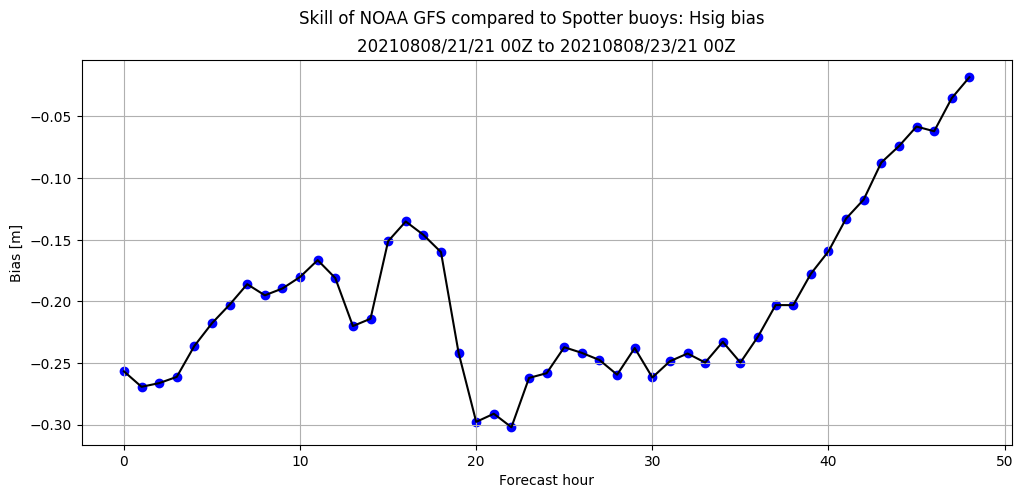

In [12]:
fig, axs = plt.subplots(
                nrows=1,  
                figsize=(12, 5),
            )
fig.suptitle("Skill of NOAA GFS compared to Spotter buoys: Hsig bias")
axs.set_title(f"{datetime.strftime(start_date, format='%Y%m%D %HZ')} to {datetime.strftime(end_date, format='%Y%m%D %HZ')}")
axs.set_xlabel("Forecast hour")
axs.set_ylabel("Bias [m]")
axs.plot(
        list(bias_by_hour.keys()),
        [bias_by_hour[h] for h in bias_by_hour],
        color="black",
        )
axs.scatter(
            list(bias_by_hour.keys()),
            [bias_by_hour[h] for h in bias_by_hour],
            color="blue",
            marker="o",
            )
axs.grid(True)
plt.show()

### Some food for thought

* What do the sign and magnitude of the bias tell you about NOAA GFS' ability to predict wave conditions in this extreme event?
* What factors might be impacting our calculation of the bias at different valid times?
* How might we change this analysis to determine which factors are most impactful when predicting conditions during this particular event? What about during extreme weather events in general?

### Opportunities to play around with the content above

* Analyze a different variable (hint, you can access the available variables with `list(ds.variables.keys())` where `ds` is a `xr.Dataset`)
* Check out another extreme weather event
* Use a different, or multiple, weather model(s)

### Summary: Important aspects to keep in mind for analysis of observation and model data

* What is your research goal? This will impact what observations, variables, model initialization and valid times to include in your analysis
* Variables can be named and defined differently between observations and models, and even between models. Ensure you are comparing apples to apples, or understand the difference between them, when relevant to your analysis
* These datasets can be quite large - filter whenever and wherever possible to make them faster and easier to work with
* Be consistent and aware of the time (timezone naive vs. aware, pd.Timestamp vs. np.datetime64) and spatial coordinates used (0, 360 or -180, 180 longitudes), especially when interpolating
* Spatial processing and mapping Python libraries can have a ton of sneaky dependencies - most packages have an installation or "getting started" guide which indicates all of the subdependencies you may need
* Be aware of the temporal coverage of your datasets
* Understand what kind of QA/QC, if any, is implemented on your observational datasets

## Appendix

#### On weather models: Forecast hours and initialization times
Operational forecast centers have a pre-determined cadence at which they initialize a model run (initialization or "init" time) to produce forecasts of future conditions. The cadence balances compute time duration and forecast accuracy by not letting too much time pass between new model initializations with more up-to-date information. This cadence is usually every 6 hours, from which conditions are typically predicted on the hour, every hour for the next 10 days. The length of these forecasts can vary; check [NOAA GFS's website](https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php) to verify what schedules their forecasts follow. 

The most accurate forecasts are those which had access to the most recent environmental and model information from the previous run, i.e. the forecast hour for which the prediction is valid (called the "valid time") is as close as possible to the initialization time. Most operational models output a forecast for forecast hour 0, called the "analysis", but some may not start until forecast 1 or later, depending on the configuration of the model. If a model is run with hourly outputs for a total forecast length of 10 days, assuming the model outputs a forecast for the zeroth hour and an initialization time of 8/8/2024 00:00 UTC, then the valid times would be 8/8/2024 00:00 UTC, 8/8/2024 01:00 UTC, 8/8/2024 02:00 UTC, ... with corresponding forecast hours 0, 1, 2, ... until hour 240. Note, the forecast length and forecast frequency can change depending on the initialization time. 

If we wanted to assess the best performance of NOAA GFS, we would use the best available forecast. NOAA GFS initializes a new forecast every 6 hours at 00:00 UTC, 06:00 UTC, 12:00 UTC, and 18:00 UTC. That would mean using forecast hours 0, 1, 2, 3, 4, 5 from the 00:00 UTC initialized model, forecast hours 0, 1, 2, 3, 4, 5 from the 06:00 UTC initialized model, and so forth.

If you poke around the directory structure of the NOAA GFS S3 bucket, you will see that this would complicate things when constructing the prefixes and filenames to query our desired datasets. In this tutorial, we evaluated the model based on a run from single initialization time, using all of the forecast hours for our period of interest, which extend well past forecast hour 5. This is not a fair assessment of NOAA GFS - feel free to try modifying the function `s3_filename_generator` and prefix(es) `noaa_gfs_prefix` to achieve this behavior (hint: you will need additional logic to modify the prefix for different initialization times).
